<a href="https://colab.research.google.com/github/sazzeb/simulated-annealing/blob/main/CSCE_5214_Assignment_3_Report_Eko_Samuel.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [6]:
import pandas as pd
import numpy as np

from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler

import matplotlib.pyplot as plt
import seaborn as sns
from typing import Sequence, Tuple
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score



## **Task 1**

In [13]:
def extract_data(filename):
    records = []
    with open(filename, 'r') as f:
        for row in f:
            if len(row) < 46:
                continue

            pid = row[25:28]
            try:
                value = int(row[41:45], 16)
            except ValueError:
                continue

            rpm = None
            speed = None

            if pid == '115':               # RPM PID
                rpm = value * 2
                speed = 0.0
            elif pid == '254':             # Speed PID
                rpm = 0.0
                speed = (value * 0.62137119) / 100
            else:
                continue                   # ignore unknown PIDs

            records.append({'RPM': rpm, 'Speed': speed})

    # build DataFrame and clean
    X = (pd.DataFrame(records)
           .dropna()
           .reset_index(drop=True)
           .apply(pd.to_numeric, errors='coerce')
           .fillna(0))

    # Remove rows where RPM or Speed is 0
    # X = X[(X['RPM'] != 0) & (X['Speed'] != 0)]

    return X[['RPM', 'Speed']]


In [14]:

fff_injection_df = extract_data('/content/sample_data/fff_injection_df.log')        # FFF speed/attack events
rpm_injection_df = extract_data('/content/sample_data/no_injection_df.log')        # Injection messages (PID-based)
no_injection_df = extract_data('/content/sample_data/rpm_injection_df.log')    # RPM readings without injection



In [15]:
scaler = StandardScaler()

In [16]:
fff_injection_df

,RPM,Speed
0,626.0,0.000000
1,0.0,0.000000
2,624.0,0.000000
3,0.0,0.000000
4,624.0,0.000000
...,...,...
14430,0.0,5.486708
14431,0.0,25.445150
14432,0.0,25.445150
14433,906.0,0.000000


In [18]:
fff_injection_df[['RPM_T', 'Speed_T']] = scaler.fit_transform(fff_injection_df[['RPM', 'Speed']])

In [19]:
rpm_injection_df[['RPM_T', 'Speed_T']] = scaler.fit_transform(rpm_injection_df[['RPM', 'Speed']])

In [20]:
no_injection_df[['RPM_T', 'Speed_T']] = scaler.fit_transform(no_injection_df[['RPM', 'Speed']])

In [21]:
fff_injection_df.describe()

,RPM,Speed,RPM_T,Speed_T
count,14435.000000,14435.000000,1.443500e+04,1.443500e+04
mean,204.939799,16.968587,7.875777e-18,2.618696e-16
std,405.795606,11.149419,1.000035e+00,1.000035e+00
min,0.000000,0.000000,-5.050496e-01,-1.521978e+00
25%,0.000000,5.486708,-5.050496e-01,-1.029854e+00
50%,0.000000,25.445150,-5.050496e-01,7.602959e-01
75%,0.000000,25.445150,-5.050496e-01,7.602959e-01
max,1772.000000,25.445150,3.861832e+00,7.602959e-01


In [22]:
rpm_injection_df.describe()

,RPM,Speed,RPM_T,Speed_T
count,1649.000000,1649.000000,1.649000e+03,1.649000e+03
mean,941.400849,7.217956,-3.447145e-17,5.170717e-17
std,945.948948,10.203310,1.000303e+00,1.000303e+00
min,0.000000,0.000000,-9.954939e-01,-7.076278e-01
25%,0.000000,0.000000,-9.954939e-01,-7.076278e-01
50%,756.000000,0.000000,-1.960540e-01,-7.076278e-01
75%,1974.000000,14.919122,1.091932e+00,7.550004e-01
max,2570.000000,29.987374,1.722179e+00,2.232249e+00


In [41]:
no_injection_df.describe()

,RPM,Speed,RPM_T,Speed_T
count,4.543000e+03,4.543000e+03,4.543000e+03,4.543000e+03
mean,-6.256154e-17,8.133001e-17,-2.502462e-17,6.256154e-17
std,1.000110e+00,1.000110e+00,1.000110e+00,1.000110e+00
min,-1.186355e+00,-4.436492e-01,-1.186355e+00,-4.436492e-01
25%,-1.174802e+00,-4.436492e-01,-1.174802e+00,-4.436492e-01
50%,8.490074e-01,-4.436492e-01,8.490074e-01,-4.436492e-01
75%,8.490074e-01,-4.436492e-01,8.490074e-01,-4.436492e-01
max,8.490074e-01,3.248646e+00,8.490074e-01,3.248646e+00


In [23]:
def optimise_k_means(data, max_k):
    """Generate elbow plot to find optimal k"""
    means = []
    inertias = []

    # Compute inertia values for different k
    for k in range(1, max_k):
        kmeans = KMeans(n_clusters=k, random_state=42)
        kmeans.fit(data)
        means.append(k)
        inertias.append(kmeans.inertia_)

    # Generate the elbow plot
    plt.figure(figsize=(10, 5))
    plt.plot(means, inertias, 'o-')
    plt.xlabel('Number of Clusters')
    plt.ylabel('Inertia')
    plt.title('Elbow Method for Optimal k')
    plt.grid(True)
    plt.show()


In [24]:
print(fff_injection_df.columns)


Index(['RPM', 'Speed', 'RPM_T', 'Speed_T'], dtype='object')


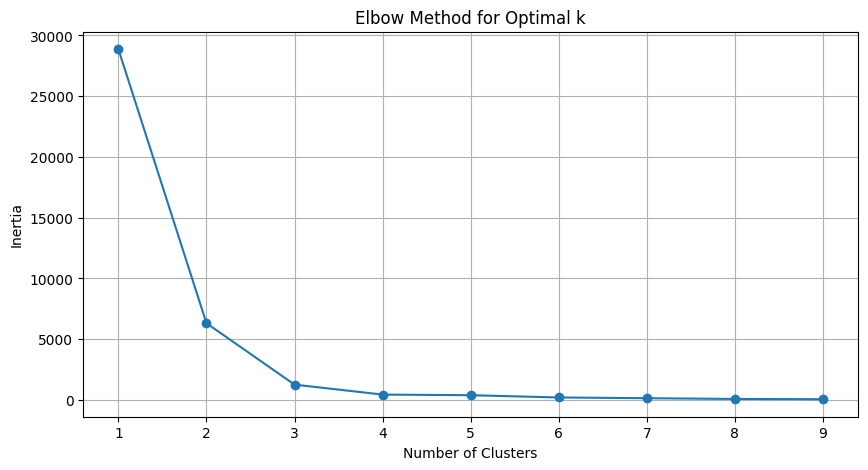

In [25]:
optimise_k_means(fff_injection_df[['RPM_T', 'Speed_T']], 10)


In [27]:

def plot_kmeans_clusters(data, k=2):
    """Scatter plot showing fitted k-means clusters"""
    kmeans = KMeans(n_clusters=k, random_state=42)
    labels = kmeans.fit_predict(data)

    plt.figure(figsize=(8, 6))
    plt.scatter(data.iloc[:, 0], data.iloc[:, 1], c=labels, cmap='viridis', s=50)
    plt.scatter(kmeans.cluster_centers_[:, 0],
                kmeans.cluster_centers_[:, 1],
                s=200, c='red', marker='X', label='Centroids')
    plt.xlabel(data.columns[0])
    plt.ylabel(data.columns[1])
    plt.title(f'K-Means Clustering (k={k}): Attack = 0 vs Attack = 1')
    plt.legend()
    plt.show()

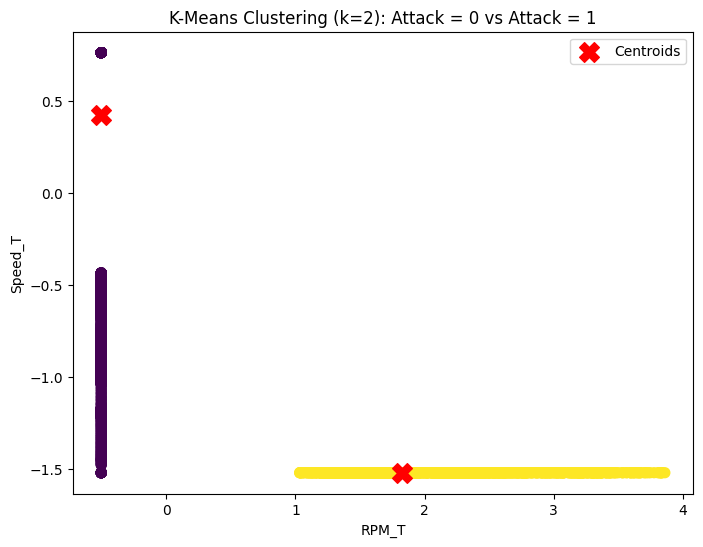

In [31]:
plot_kmeans_clusters(fff_injection_df[['RPM_T', 'Speed_T']], k=2)